# Mapper Inference

In [1]:
import time
import torch
from torch.nn import functional as F
from tqdm.notebook import tqdm
import torchvision.transforms as tt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from src.loader import Loader
from src.utilities import generate_image, show_image, temporarily_add_to_path
from src.encoder import prepare_image_to_inversion
from PIL import Image
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Loading models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = Loader(device)
stylegan = loader.load_stylegan()
encoder, encoder_opts = loader.load_encoder("./editing/restyle_pSp_ffhq.pt") # Change path to your encoder
latent_mapper = loader.load_pretrained_mapper("./mappers/beard.pt") # Change path to your pre-trained mapper

## Editing generated images

Editing generated images is simpler because we know latent from start. Let's generate one for example

In [ ]:
original_image, original_w, original_z = generate_image(stylegan, device)
show_image(original_image)

## Editing real images

This task is a bit more tricky as we need to get latents from real images first. So there are two ways to do that

### Pre-trained Encoder

This method assumes that we have downloaded pre-trained stylegan3-encoder. This model constructed to encode images into latent space.

Before editing real images with encoder please place the downloaded one into the **./images/real** folder. 

This is necessary because when preparing an image, its intermediate converted versions are saved in the corresponding folders (**./images/cropped**, **./images/aligned** and **./images/latents** for latents)

Aligning image...
Finished aligning image: ./images/real/62.jpg
Cropping image...
Finished cropping image: ./images/real/62.jpg
Computing landmarks-based transforms...
Done!
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


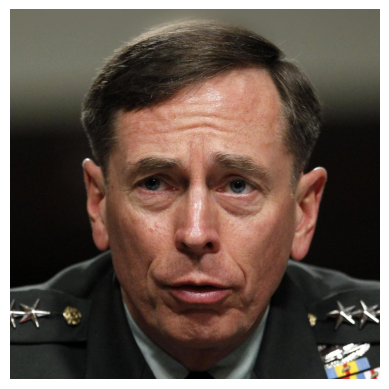

In [3]:
IMAGE_NAME = "your image name" # Be sure that it is in correct folder
IMAGE_NAME = "62.jpg"
real_image, image_to_edit, average_image, landmarks_transform = prepare_image_to_inversion(IMAGE_NAME, encoder)
show_image(real_image)

In [4]:
def get_latents(image, avg_image,landmarks_transform, n_latents = 5):
    encoder_opts.resize_outputs = False
    encoder_opts.n_iters_per_batch = n_latents
    with temporarily_add_to_path("./editing"):
        from utils.inference_utils import run_on_batch
        with torch.no_grad():
            tic = time.time()
            result_batch, result_latents = run_on_batch(inputs=image.unsqueeze(0).cuda().float(),
                net=encoder,
                opts=encoder_opts,
                avg_image=avg_image,
                landmarks_transform=torch.from_numpy(landmarks_transform).cuda().float())
            toc = time.time()
            print('Inference took {:.4f} seconds.'.format(toc - tic))
            print(result_latents[0][0].shape)
            return result_batch, result_latents

Now it's time to get our latents. The output will be multiple latents which will be extracted on every iteration from real image. Usually the 5th is the highest quality, because artifacts begin to appear later.

In [5]:
result_batch, result_latents = get_latents(image_to_edit, average_image, landmarks_transform, n_latents=5)

Inference took 1.5650 seconds.
(16, 512)


If you wish you can change -1 below to whatever index you want (from 0 to n_latents -1 ). You can also check the difference between restored images from different latents.

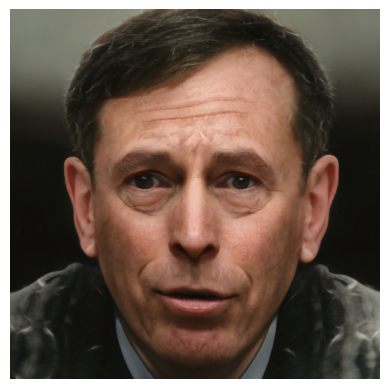

In [10]:
latent = torch.from_numpy(result_latents[0][-1]).unsqueeze(0)
restored_image = ((stylegan.synthesis(latent.to(device)) + 1) * 0.5).clamp(0,1).cpu()
show_image(restored_image)

### Latent Vector Optimization

This way is pretty similar to optimization of a latent vector for image editing. But for now we will try to optimize random vector so that after restoration the image will be similar to the original one.
It's also some less efficient and has lower quality then pre-trained encoder

First of all let's load image and prepare it to encoding

In [3]:
def prepare_image(image_path):
    transform = tt.Compose([
        tt.Resize((1024, 1024)),
        tt.ToTensor(),
        tt.Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path,"r").convert("RGB")
    image_tensor = (transform(image).unsqueeze(0).to(device) + 1) * 0.5
    return image_tensor

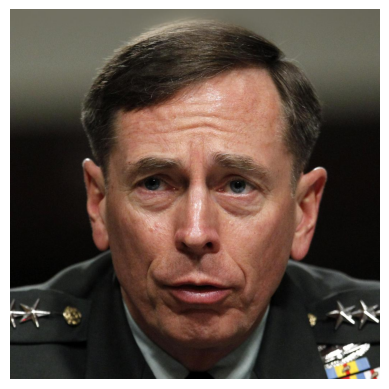

In [4]:
IMAGE_PATH = "path_to_your_image"
IMAGE_PATH = "./images/real/62.jpg"
real_image = prepare_image(IMAGE_PATH)
show_image(real_image)

Now it's time to find latent vector via optimization method

In [5]:
def optimize_latent(
    real_image,
    num_steps=1000,
    w_avg_samples = 10000,
    initial_lr=0.03,
    initial_noise_factor = 0.05,
    lr_rampdown_length = 0.25,
    lr_rampup_length = 0.05,
    noise_ramp_length = 0.75,
    regularize_noise_weight = 1e5,
):

    z_samples = np.random.RandomState(123).randn(w_avg_samples, stylegan.z_dim)
    w_samples = stylegan.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    noise_bufs = { name: buf for (name, buf) in stylegan.synthesis.named_buffers() if 'noise' in name }

    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with temporarily_add_to_path("./stylegan3"):
        from stylegan3 import dnnlib
        with dnnlib.util.open_url(url) as f:
            vgg16 = torch.jit.load(f).eval().to(device)

    target_images = (real_image * 255).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    # print(target_images.size())
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    # print(f"{w_opt.size()=}")
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_lr)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in tqdm(range(num_steps)):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_lr * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, stylegan.mapping.num_ws, 1])
        synth_images = stylegan.synthesis(ws, noise_mode='const')
        to_show = (synth_images.detach().clone() + 1) / 2

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * 255 / 2
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        if step % 10 == 0:
            clear_output(True)
            print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
            show_image(to_show)
            plt.show()

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    torch.cuda.empty_cache()
    return w_out.repeat([1, stylegan.mapping.num_ws, 1]).cpu()

step  991/1000: dist 0.31 loss 0.31 


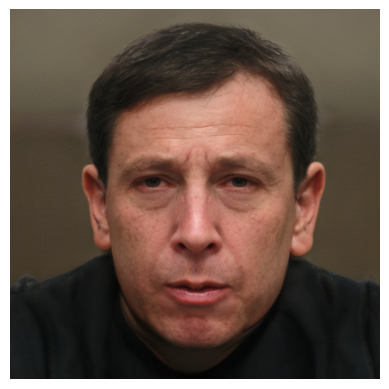

In [6]:
latents = optimize_latent(real_image)
latent = latents[-1].unsqueeze(0)
restored_image = ((stylegan.synthesis(latent.to(device)) + 1) * 0.5).cpu()
torch.cuda.empty_cache()

Great! Our latent is ready!

Unfortunately styling this vector via latent mapper isn't possible, probably because of it's values doesn't lay into [-1,1]. Even after normalization **(latent /= latent.abs().max())**. Even if normalize it in optimization process... So the results may be unpredictable. 

But we still can style it via optimization! 

## Latent Mapper

Let's start to edit image by the latent mapper!

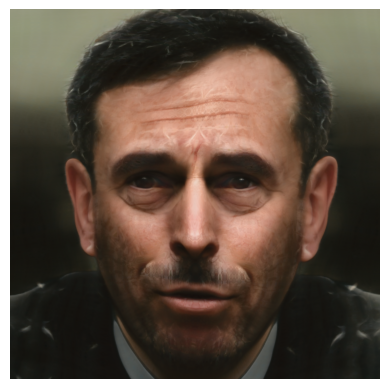

In [11]:
styled_latent = latent + latent_mapper(latent.to(device)).cpu()
styled_image = ((stylegan.synthesis(styled_latent.to(device)) + 1) * 0.5).clamp(0,1).detach().cpu()
show_image(styled_image)

Here we are! Let's check the difference

In [12]:
def compare_images(real, restored, styled):
    images = [real,restored, styled]
    fig, axes = plt.subplots(1, len(images), figsize=(20, 8))
    for idx, ax in enumerate(axes.flatten()):
        img = images[idx].cpu().squeeze().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

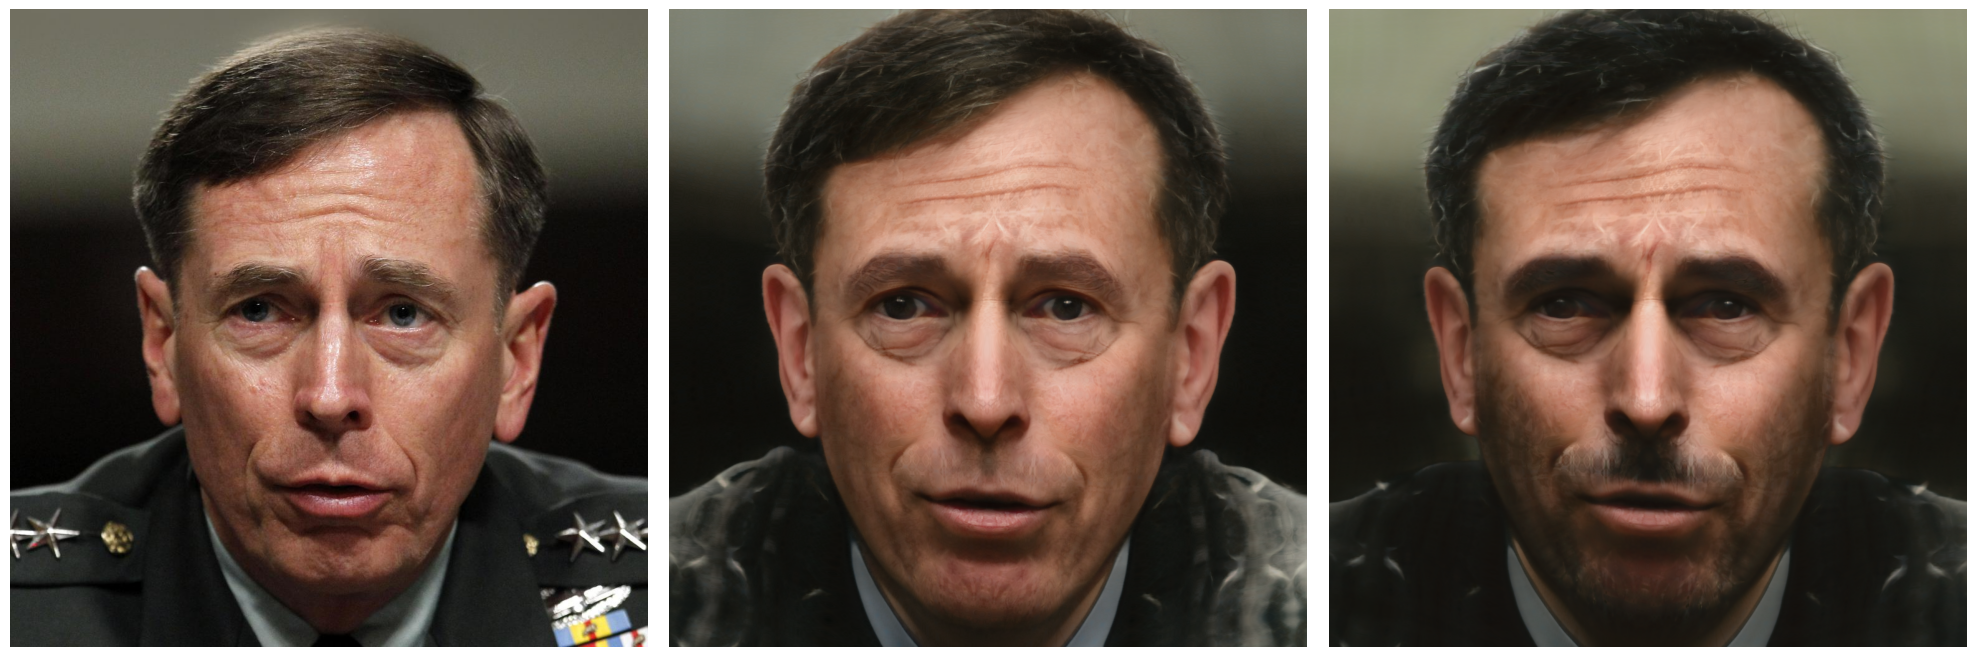

In [13]:
compare_images(real_image, restored_image, styled_image)